## NODE_A RT1 Assignment 2

Bla bla

In [1]:
#!/usr/bin/env python3

import jupyros as jr
import rospy
import sys
import select
import actionlib
import time
import actionlib.msg
import Assignment_2.msg
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Point, Pose, Twist, PoseStamped
from Assignment_2.msg import Info
from Assignment_2.srv import target,targetResponse
import assignment_2_2022.msg
from sensor_msgs.msg import LaserScan


import ipywidgets as widgets
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook

In [2]:
class Visualiser:
    
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [] , []
    
    def plot_init(self):
        self.ax.set_xlim(8, -8)
        self.ax.set_ylim(8, -8)
        return self.ln
    
    def odom_callback(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)
    
    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln

    def add_goal(self, x, y):
        self.ax.plot(x, y, marker="x",markeredgecolor="blue")

In [3]:
class VisualiserGoals:
    
    def __init__(self):
        self.fig, self.ax = plt.subplots()      
        self.res = ['success','canceled']
        self.n_goals = [0,0]
        self.bar_colors = ['tab:green','tab:red']        
        self.bar = self.ax.bar(self.res, self.n_goals, color= self.bar_colors)    
        self.ax.set_title('Number of goals reached and canceled')        
              
    def update(self, s, c):
        self.bar = self.ax.bar(self.res, [s,c], color=self.bar_colors)    

In [4]:
#Global variables
pose_ = Pose()
twist_ = Twist()

#state
s = 0

#Initialization of elements
pose = PoseStamped()
target_reached = 0
target_canceled = 0

In [5]:
#Input Float for goal
x_w = widgets.BoundedFloatText(value=0, min=-10, max=10, description='x position to reach: ', disabled=False)
y_w = widgets.BoundedFloatText(value=0, min=-10, max=10, description='y position to reach: ', disabled=False)

#Plot
x_plot = []
y_plot = []
np_x_plot = np.array(x_plot)
np_y_plot = np.array(y_plot)

goal_x = 0
goal_y = 0

#Buttons
send_btn = widgets.Button(description="Send Goal")
cancel_btn = widgets.Button(description="Cancel")

#Labels
goal_reached_label = widgets.Text(value='0',description='Goals reached: ', disabled=True)
goal_canceled_label = widgets.Text(value='0',description='Goals canceled: ', disabled=True)
distance_obj = widgets.Text(value='0.0', description='Distance to Obstacle', disabled=True)

In [6]:
#Init node
rospy.init_node('node_a')

#Create a new client
client = actionlib.SimpleActionClient('/reaching_goal', assignment_2_2022.msg.PlanningAction)

#Publish
pub_info = rospy.Publisher('/bot_info', Info, queue_size=1)
pub_target = rospy.Publisher('/tgt', Point, queue_size=1)

In [7]:
def send_goal(b):
    
    global client, target_reached, s
    
    pose = PoseStamped()
    
    pose.pose.position.x = x_w.value
    pose.pose.position.y = y_w.value
    pose.pose.position.z = 0
    
    #Create the object PlanningGoal and assign the position goal
    goal = assignment_2_2022.msg.PlanningGoal(target_pose = pose)

    #Send the goal request
    client.send_goal(goal)  
    
    vis.add_goal(x_w.value,y_w.value)
    
    s = 1
        
send_btn.on_click(send_goal)    

In [8]:
def canc_goal(b):
    
    global client, target_canceled, state
    
    client.cancel_all_goals()
    time.sleep(1)
    state = client.get_state()    
    if state == 2:        
        target_canceled += 1
        vix_goals.update(target_reached,target_canceled)
        #goal_canceled_label.value = str(target_canceled)
        
cancel_btn.on_click(canc_goal)

In [9]:
def clbk_odom(msg):
    
    global client, target_reached, s, x_plot, y_plot

    x_ = msg.pose.pose.position.x
    y_ = msg.pose.pose.position.y
    vx_ = msg.twist.twist.linear.x
    vy_ = msg.twist.twist.linear.y

    msg_info = Info()

    msg_info.x = x_
    msg_info.y = y_
    msg_info.vel_x = vx_
    msg_info.vel_y = vy_    
    
    state = client.get_state()
    if(state == 3 and s == 1):
        target_reached += 1
        #goal_reached_label.value = str(target_reached)
        vix_goals.update(target_reached,target_canceled)
        
        s = 0
        
    if not rospy.is_shutdown():
        pub_info.publish(msg_info)

In [10]:
def ltk_tgt(x, y):

    global pub_target

    target = Point()

    target.x = x
    target.y = y
    target.z = 0

    pub_target.publish(target)

In [11]:
def get_info_goal(req):

    global target_reached, target_canceled, service
    
    return targetResponse(target_reached, target_canceled)

In [12]:
def clbk_laser(msg):
    
    _range = msg.ranges
    min_dst = sys.float_info.max
    
    for x in _range:
        if(x < min_dst):
            min_dst = x
    
    distance_obj.value = str(min_dst)

In [13]:
#Wait for the server ready 
client.wait_for_server()   

True

# UI

In [14]:
#Subscribe
sub_odom = rospy.Subscriber('/odom', Odometry, clbk_odom)
service = rospy.Service('goal_info',target, get_info_goal)
sub_laser = rospy.Subscriber('/scan', LaserScan, clbk_laser)

<IPython.core.display.Javascript object>


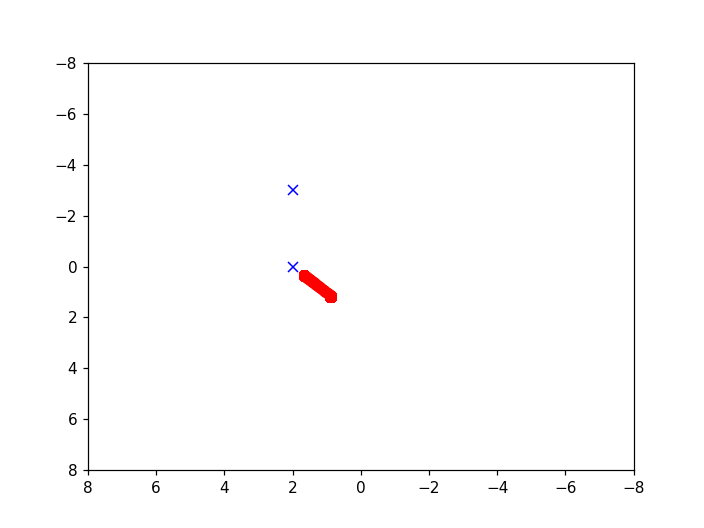

In [15]:
vis = Visualiser()
sub = rospy.Subscriber('/odom', Odometry, vis.odom_callback)

ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)
plt.show(block=True)

In [16]:
display(distance_obj)

Text(value='1.3922184705734253', description='Distance to Obstacle', disabled=True)

<IPython.core.display.Javascript object>


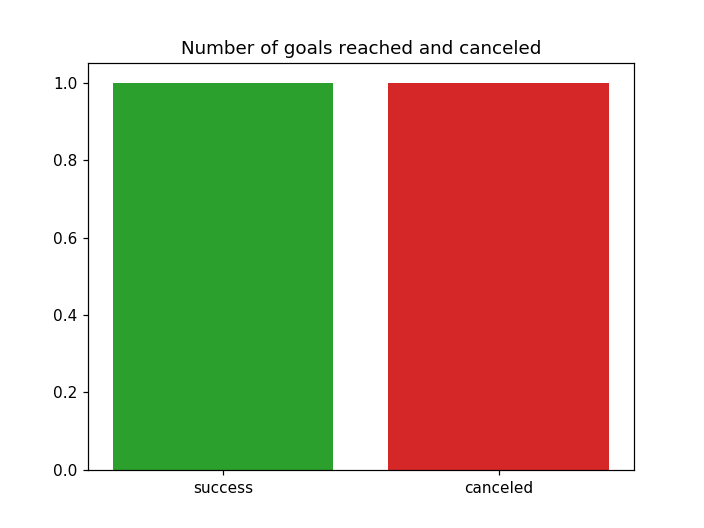

In [17]:
vix_goals = VisualiserGoals()

In [18]:
display(x_w,y_w)
HBox([send_btn,cancel_btn])

BoundedFloatText(value=0.0, description='x position to reach: ', max=10.0, min=-10.0)

BoundedFloatText(value=0.0, description='y position to reach: ', max=10.0, min=-10.0)